Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd
print("pandas: ", pd.__version__)
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

pandas:  1.1.0
torch:  1.6.0
numpy:  1.19.1


In [2]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/media/wsubuntu/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

In [3]:
khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

sys.path.insert(1, khs_dir)
import helperFuncs as funcH

def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    uniq_pred_ids = np.unique(pred_vec)
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn, uniq_pred_ids

funcH.setPandasDisplayOpts()

# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

wsubuntu_khs_dir = /home/wsubuntu/GitHub/keyhandshapediscovery
wsubuntu_data_path = /media/wsubuntu/SSD_Data/DataPath
wsubuntu_experiment_path = /media/wsubuntu/SSD_Data/vaesae_experiments
cpu


Constructing the Argument Parsers

In [4]:
EXPERIMENT_ID = 40
LOSS_TYPE='cre'
LOSS_REDUCTION='mean' #'batchmean','sum'
LOSS_ACT='sigmoid'
APPLY_LOG_SOFTMAX=False
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

epochs = 30  # args['epochs']
REG_PARAM = 0.0001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [5]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(root=FOLDERS["data"], train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root=FOLDERS["data"],train=False,download=True,transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [6]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type, enc_loss_act):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=32)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.enc_loss_act=enc_loss_act
        self.device = get_device()
        print("SparseAutoencoder - loss_type(" + loss_type +"), enc_loss_act(" + enc_loss_act +"), device(" + self.device + ")")

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        if self.enc_loss_act=='sigmoid':
            bottleneck = torch.sigmoid(self.enc5(x))
        else:#relu
            bottleneck = F.relu(self.enc5(x))  
        
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE, enc_loss_act=LOSS_ACT).to(device)

SparseAutoencoder - loss_type(cre), enc_loss_act(sigmoid), device(cpu)


In [7]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [9]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    rho_val = 1/bt.size(1)
    rho_mat = torch.tensor([rho_val] * np.ones(bt.size()), dtype=torch.float32).to(device)
    #https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/13
    #KLDLoss(p, q), sum(q) needs to equal one
    #p = log_softmax(tensor)
    loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, reduction, apply_log_softmax, print_info):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    _, preds = torch.max(bottleneck, 1)
    if print_info:
        print("apply_log_softmax:",apply_log_softmax)
        print("bottleneck in :",bottleneck)

    if apply_log_softmax:
        loss_ret_1 = loss_fun(F.log_softmax(bottleneck, dim=1).to(device), preds)
    else:
        loss_ret_1 = loss_fun(bottleneck.to(device), preds)
    return loss_ret_1

In [10]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
        if print_info:
            print("bottleneck out:",bottleneck)
    if print_info:
        print(loss_type,loss)
    return loss

In [11]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - REG_PARAM * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + REG_PARAM * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn, uniq_pred_ids = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df, uniq_pred_ids

In [12]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn, uniq_pred_ids = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df, uniq_pred_ids

In [14]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_ACT : ", LOSS_ACT)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("APPLY_LOG_SOFTMAX : ", APPLY_LOG_SOFTMAX)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param(" + "{:.5f}".format(REG_PARAM) + ") * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr, uniq_pred_ids_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va, uniq_pred_ids_va = validate(model, testloader, epoch, print_losses_fit)
    print("uniq_pred_ids_tr:", uniq_pred_ids_tr)
    print("uniq_pred_ids_va:", uniq_pred_ids_va)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time() 
print(f"{(end-start)/60:.3} minutes")
mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws :: 
EXPERIMENT_ID:  40
LOSS_TYPE :  cre
LOSS_ACT :  sigmoid
LOSS_REDUCTION :  mean
APPLY_LOG_SOFTMAX :  False
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param(0.00010) * sp_loss
*****
 Epoch 0 of 30
TrEpoch(000) - apply_log_softmax: False
bottleneck in : tensor([[0.5159, 0.4771, 0.4735,  ..., 0.4996, 0.4677, 0.5269],
        [0.5152, 0.4775, 0.4722,  ..., 0.4997, 0.4665, 0.5266],
        [0.5159, 0.4776, 0.4733,  ..., 0.5000, 0.4689, 0.5249],
        ...,
        [0.5159, 0.4792, 0.4748,  ..., 0.5000, 0.4688, 0.5251],
        [0.5155, 0.4779, 0.4748,  ..., 0.4985, 0.4674, 0.5260],
        [0.5149, 0.4783, 0.4712,  ..., 0.5020, 0.4689, 0.5267]],
       grad_fn=<SigmoidBackward>)
bottleneck out: tensor([[0.5159, 0.4771, 0.4735,  ..., 0.4996, 0.4677, 0.5269],
        [0.5152, 0.4775, 0.4722,  ..., 0.4997, 0.4665, 0.5266],
        [0.5159, 0.4776, 0.4733,  ..., 0.5000, 0.4689, 0.5249],
        ...,
        [0.5159, 0.4792, 0.4748,  ..., 0.5000, 0.4688, 0.5251],
   

ValEpoch(014) - 
      acc    bmx    bmn     run
0  21.47  0.996  0.005  10.603
uniq_pred_ids_tr: [ 0  4  5  7  8 15 16 17 19 20 22 23 25 27 28 29 30 31]
uniq_pred_ids_va: [ 0  4  5  7  8 15 16 17 19 20 22 23 25 27 29 30 31]
*****
 Epoch 15 of 30
TrEpoch(015) - 
       acc    bmx    bmn     mse       spr     run
0  20.262  0.998  0.006  62.054  5775.112  62.631
ValEpoch(015) - 
      acc    bmx    bmn     run
0  19.74  0.994  0.004  10.048
uniq_pred_ids_tr: [ 0  4  5  7  8 15 16 17 19 20 22 23 25 27 28 29 30 31]
uniq_pred_ids_va: [ 0  4  5  7  8 15 16 17 19 20 22 23 25 27 29 30 31]
*****
 Epoch 16 of 30
TrEpoch(016) - apply_log_softmax: False
bottleneck in : tensor([[0.1230, 0.3037, 0.3539,  ..., 0.4941, 0.1631, 0.6964],
        [0.2842, 0.1510, 0.5688,  ..., 0.7475, 0.3400, 0.3592],
        [0.6583, 0.2800, 0.5657,  ..., 0.7384, 0.3305, 0.1068],
        ...,
        [0.9038, 0.3072, 0.6849,  ..., 0.9314, 0.7643, 0.5789],
        [0.7143, 0.5649, 0.7313,  ..., 0.7225, 0.7790, 0.5517],


TrEpoch(029) - 
      acc  bmx    bmn     mse       spr     run
0  16.79  1.0  0.007  52.954  5674.085  53.521
ValEpoch(029) - 
      acc    bmx    bmn    run
0  20.72  0.999  0.005  8.897
uniq_pred_ids_tr: [ 1  5  8 15 16 17 19 22 23 25 27 28 29 30 31]
uniq_pred_ids_va: [ 1  5  8 15 16 19 22 23 25 27 28 29 30 31]
11.0 minutes


In [15]:
print(result_df_tr_all)

       acc    bmx        bmn      mse       spr      run
0   23.130  1.000  5.967e-05  165.601  5999.266  166.201
1   31.312  0.992  1.245e-02  110.782  6014.105  111.383
2   32.453  0.997  1.527e-02   98.510  5959.968   99.106
3   34.020  0.998  1.762e-02   91.013  5950.017   91.608
4   34.143  0.995  1.504e-02   85.431  5945.190   86.025
5   35.290  0.992  1.336e-02   80.697  5941.376   81.291
6   33.790  0.990  1.179e-02   76.854  5924.046   77.446
7   36.112  0.989  1.101e-02   72.707  5917.518   73.299
8   34.773  0.990  1.160e-02   70.589  5908.913   71.180
9   32.770  0.993  9.672e-03   69.268  5883.072   69.856
10  27.540  0.995  7.901e-03   67.859  5853.200   68.445
11  26.217  0.997  7.965e-03   66.725  5828.267   67.308
12  24.775  0.997  7.698e-03   65.536  5807.655   66.117
13  23.930  0.997  6.106e-03   64.656  5792.224   65.235
14  24.820  0.998  6.170e-03   63.521  5777.222   64.098
15  20.262  0.998  6.197e-03   62.054  5775.112   62.631
16  21.885  0.996  5.225e-03   

In [16]:
print(result_df_va_all)

      acc    bmx    bmn     run
0   30.98  0.986  0.042  19.145
1   43.25  0.991  0.021  17.338
2   33.14  0.998  0.023  15.566
3   32.38  0.996  0.018  14.729
4   27.17  0.993  0.016  13.766
5   33.87  0.989  0.012  13.299
6   28.52  0.985  0.012  12.466
7   26.95  0.987  0.011  11.884
8   34.72  0.991  0.007  11.752
9   28.70  0.992  0.008  11.463
10  26.28  0.995  0.006  11.259
11  24.22  0.996  0.007  11.116
12  25.06  0.997  0.005  10.972
13  23.12  0.997  0.004  10.702
14  21.47  0.996  0.005  10.603
15  19.74  0.994  0.004  10.048
16  19.80  0.993  0.004   9.957
17  23.25  0.993  0.004   9.740
18  19.39  0.993  0.005   9.580
19  18.66  0.995  0.005   9.518
20  21.90  0.996  0.005   9.491
21  21.38  0.997  0.006   9.408
22  21.15  0.998  0.006   9.375
23  20.95  0.998  0.006   9.351
24  21.21  0.998  0.006   9.238
25  21.49  0.998  0.005   9.182
26  21.33  0.998  0.006   9.165
27  21.22  0.999  0.005   8.971
28  20.81  0.999  0.005   8.930
29  20.72  0.999  0.005   8.897


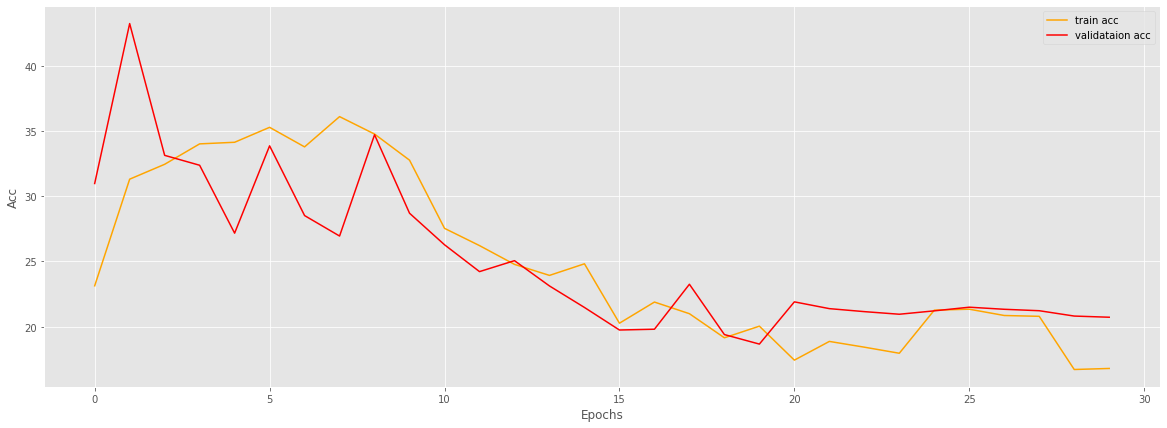

Max tr acc =  36.111666666666665
Max va acc =  43.25


In [17]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

all(6014.10), trmse(36.00), trspr(1.00), vaerr(314.00)


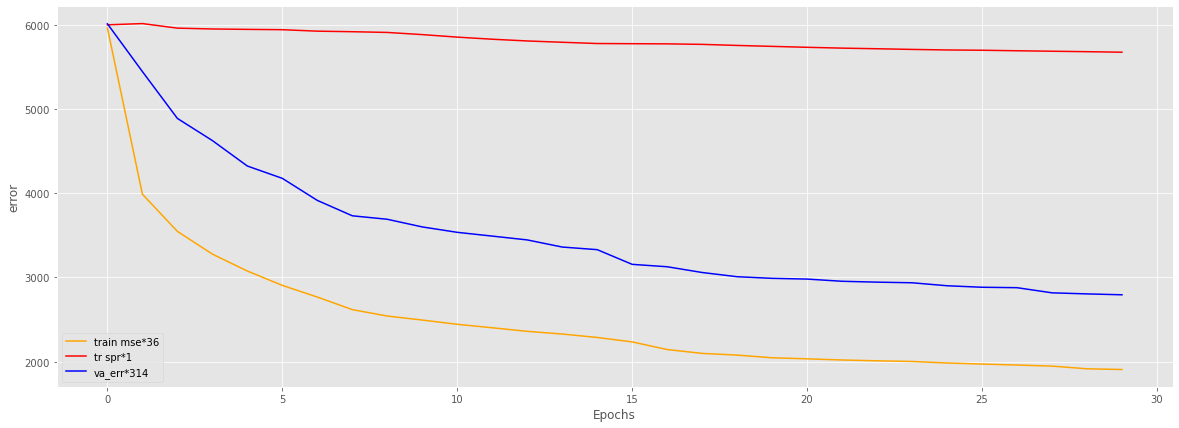

In [18]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr = result_df_tr_all.values[:,4].squeeze()
va_err = result_df_va_all.values[:,-1].squeeze()

mx_all = np.max([tr_mse, tr_spr, va_err])
tr_mse_mul = int(mx_all/np.max(tr_mse))
tr_spr_mul = int(mx_all/np.max(tr_spr))
va_err_mul = int(mx_all/np.max(va_err))
print("all({:.2f}), trmse({:.2f}), trspr({:.2f}), vaerr({:.2f})".format(mx_all, tr_mse_mul, tr_spr_mul, va_err_mul))

plt.figure(figsize=(20, 7))
plt.plot(tr_mse*tr_mse_mul, color='orange', label='train mse*'+str(tr_mse_mul))
plt.plot(tr_spr*tr_spr_mul, color='red', label='tr spr*'+str(tr_spr_mul))
plt.plot(va_err*va_err_mul, color='blue', label='va_err*'+str(va_err_mul))
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()